<a href="https://colab.research.google.com/github/Thabet-Chaaouri/Sentence_similarity/blob/main/clustering_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U sentence-transformers
!pip install umap-learn
!pip install datasets
!pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.7 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=40845577b71a45465a6f746c5bce9d115649e88ae1a7709016e3cb02aa3f04f3
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 6.7 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from huggingface_hub import notebook_login

notebook_login()

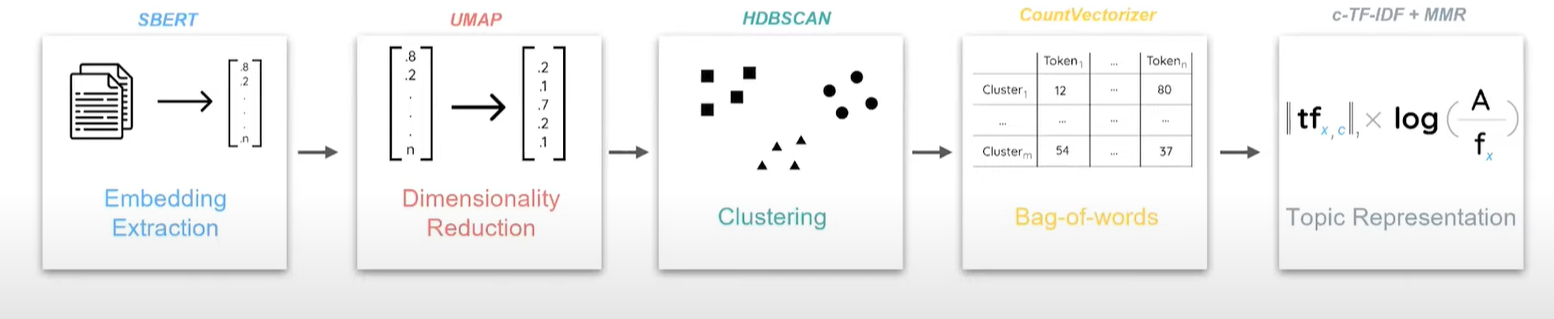

# Selecting a small dataset for experimenting

In [ ]:
from datasets import load_dataset
embeddings_dataset = load_dataset("Thabet/embeddings_dataset", split="train")
small_dataset = embeddings_dataset.shuffle(seed=42).select(range(10000))
small_dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/119520 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Thabet___parquet/Thabet--embeddings_dataset-17762ce5c75be3cd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Dataset({
    features: ['titre_sb', 'id_objet_SB', 'id_objet_container', 'Nature_SB', 'Résumé', 'Lieu', 'origine(s)', 'Rédacteur', 'validé/réfusé le', 'Destination_SB', 'Catégorie(s)', 'date_creation', 'date_début', 'date_fin', 'validé/réfusé par', '__index_level_0__', 'text', 'embeddings'],
    num_rows: 10000
})

Text cleaning:
- departement cleansing : D51 or D 80 or 79 - or d10
- Contact information : https:// , x@y.fr or .com , Mail envoyé à l'éditeur : , contact presse :,  Contact :, 06*** , cordialement, bonne journnée 

In [ ]:
import re

def clean_title(titre):
  return re.sub(r'^[d\d][\s\d]+','',titre.lower())

def clean_summary(summary):
  summary=summary.lower()
  res = re.sub(r'[\w.-]+@[\w.-]+','',summary)
  res = re.sub(r'(cordialement|bonne journnée|contact)[\W\w\s]+','',res)
  res = re.sub(r'06[\s\d]+','',res)
  res = re.sub(r'https[\W]+[\w\d]+','',res)
  return res


def check_field(examples, field):
    if examples[field] is None:
        return ""
    else:
        return (" \n " + clean_summary(examples[field]))
    

def concatenate_text(examples):
    return {
        "sb_text":clean_title(examples["titre_sb"])
        + check_field(examples, "Résumé")
    }



In [ ]:
small_dataset = small_dataset.map(concatenate_text)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

model_ckpt = "Thabet/sb_sentence_transformer"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

In [ ]:
device = torch.device("cuda")
model.to(device)

def cls_pooling(model_output):
    return model_output.last_hidden_state[:, 0]

def get_embeddings(text_list):
    encoded_input = tokenizer(
        text_list, padding=True, truncation=True, return_tensors="pt"
    )
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    model_output = model(**encoded_input)
    return cls_pooling(model_output)

In [ ]:
small_dataset = small_dataset.map(
    lambda x: {"embeddings_y": get_embeddings(x["sb_text"]).detach().cpu().numpy()[0]}
)
small_dataset

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset({
    features: ['titre_sb', 'id_objet_SB', 'id_objet_container', 'Nature_SB', 'Résumé', 'Lieu', 'origine(s)', 'Rédacteur', 'validé/réfusé le', 'Destination_SB', 'Catégorie(s)', 'date_creation', 'date_début', 'date_fin', 'validé/réfusé par', '__index_level_0__', 'text', 'embeddings', 'sb_text', 'embeddings_y'],
    num_rows: 10000
})

#Lowering dimensionality

In [ ]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=30, 
                            metric='cosine').fit_transform(small_dataset["embeddings_y"])
corpus_embeddings = umap_embeddings

# Selecting n_clusters parameter

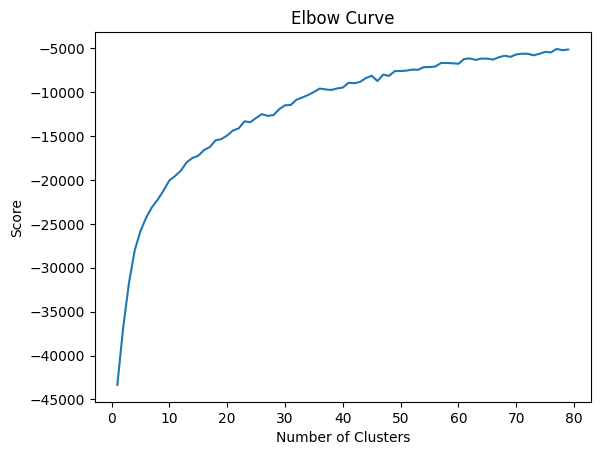

In [ ]:
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np

# Standardize the data
#corpus_embeddings = small_dataset["embeddings_y"] /  np.linalg.norm(small_dataset["embeddings_y"], axis=1, keepdims=True)

# Run a number of tests, for 1, 2, ... num_clusters
num_clusters = 80
kmeans_tests = [KMeans(n_clusters=i, init='random', n_init=10) for i in range(1, num_clusters)]
score = [kmeans_tests[i].fit(corpus_embeddings).score(corpus_embeddings) for i in range(len(kmeans_tests))]

# Plot the curve
plt.plot(range(1, num_clusters),score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

# Runing K-means on a small data

In [ ]:
import numpy as np

num_clusters = 20
#corpus_embeddings = small_dataset["embeddings_y"] /  np.linalg.norm(small_dataset["embeddings_y"], axis=1, keepdims=True)

clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=20)

In [ ]:
cluster_assignment = clustering_model.labels_
small_dataset = small_dataset.remove_columns("cluster")
small_dataset = small_dataset.add_column("cluster", cluster_assignment)
small_dataset

Dataset({
    features: ['titre_sb', 'id_objet_SB', 'id_objet_container', 'Nature_SB', 'Résumé', 'Lieu', 'origine(s)', 'Rédacteur', 'validé/réfusé le', 'Destination_SB', 'Catégorie(s)', 'date_creation', 'date_début', 'date_fin', 'validé/réfusé par', '__index_level_0__', 'text', 'embeddings', 'sb_text', 'embeddings_y', 'cluster'],
    num_rows: 10000
})

#Runing HDBScan on small data

In [ ]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=20,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(corpus_embeddings)

In [ ]:
cluster_assignment = cluster.labels_
#small_dataset = small_dataset.remove_columns("cluster")
small_dataset = small_dataset.add_column("cluster", cluster_assignment)
small_dataset

Dataset({
    features: ['titre_sb', 'id_objet_SB', 'id_objet_container', 'Nature_SB', 'Résumé', 'Lieu', 'origine(s)', 'Rédacteur', 'validé/réfusé le', 'Destination_SB', 'Catégorie(s)', 'date_creation', 'date_début', 'date_fin', 'validé/réfusé par', '__index_level_0__', 'text', 'embeddings', 'sb_text', 'embeddings_y', 'cluster'],
    num_rows: 10000
})

#Projection on 2D plot

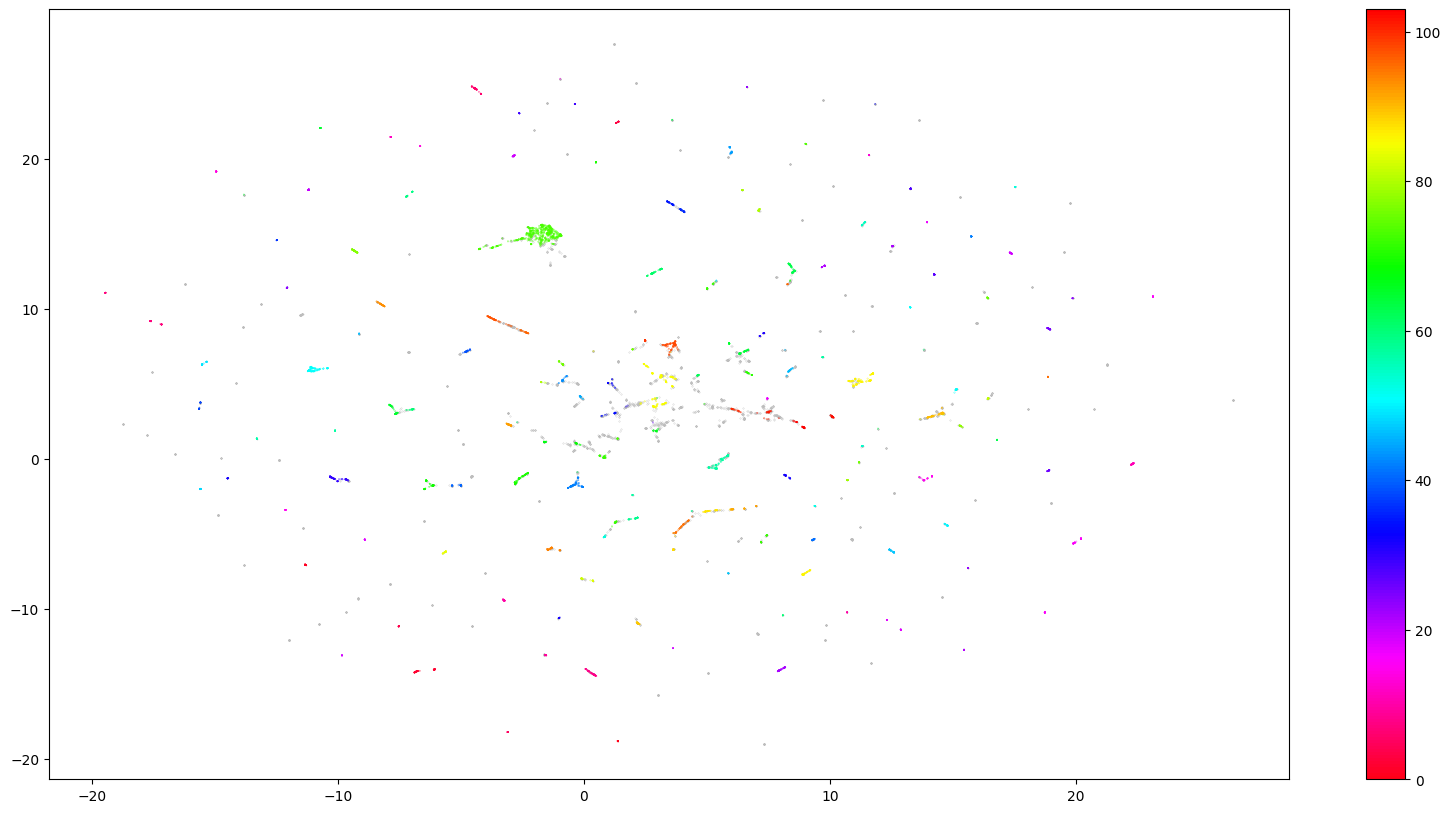

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(corpus_embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster_assignment

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

# Topic creation

In [ ]:
import pandas as pd
data = small_dataset["sb_text"]
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = small_dataset["cluster"]
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': '\n*********\n'.join})
docs_per_topic

,Topic,Doc
0,-1,préparatifs iron man à vichy\n*********\nregle...
1,0,dordogne manque d'assesseurs 24p\n*********\nd...
2,1,"belgique - famiflora sous scellés, 3000 sapins..."
3,2,_méthaniseur de guéret \n*********\nincendie a...
4,3,"valp lieu culturel 40 \n le « 40 », nouveau pô..."
...,...,...
100,99,: contrôles police corsica ferries\n*********\...
101,100,manif fsu enseignants\n*********\nm_professeu...
102,101,manifestations grève du 7 mars\n*********\nman...
103,102,les petits boulots des retraités\n*********\nd...


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.fr.stop_words import STOP_WORDS

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=list(STOP_WORDS)).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neuf', 'qu', 'quelqu'] not in stop_words.
  warnings.warn(


In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,3665
74,73,613
87,86,234
86,85,200
52,51,172
58,57,151
73,72,144
43,42,139
71,70,132
66,65,132


In [ ]:
#[top_n_words[topic][0] for topic in list(topic_sizes["Topic"])]

In [ ]:
top_n_words[84][:10] # ==> carburants et raffinerie

[('carburant', 0.3563653574562713),
 ('carburants', 0.3107304049211096),
 ('prix', 0.16825576264122893),
 ('essence', 0.12429216196844384),
 ('raffinerie', 0.1043206134780839),
 ('centimes', 0.10134536612722778),
 ('total', 0.08286144131229589),
 ('cheque', 0.07824046010856292),
 ('transporteurs', 0.07824046010856292),
 ('remise', 0.0761844374734627)]

In [ ]:
top_n_words[86][:10] #Elections

[('législatives', 0.1813579862103896),
 ('tour', 0.1274392008462651),
 ('legislatives', 0.1113307504483076),
 ('vote', 0.08446935915434867),
 ('présidentielle', 0.07848949594718024),
 ('campagne', 0.07158359877394072),
 ('politique', 0.06357530342791548),
 ('circo', 0.062179765500008706),
 ('circonscription', 0.062179765500008706),
 ('réactions', 0.049341248858531084)]

In [ ]:
top_n_words[41][:10] # vacances et tourisme

[('tourisme', 0.4147990944992827),
 ('touristes', 0.271175848819164),
 ('touristique', 0.24299384624188133),
 ('bilan', 0.22314158355332256),
 ('vacances', 0.15392721539797363),
 ('étrangers', 0.09210340371976183),
 ('saison', 0.09065718236093993),
 ('frequentation', 0.06594294135776115),
 ('ascension', 0.06338576738041198),
 ('réservations', 0.062338807063466346)]

In [ ]:
top_n_words[57][:10] # ==> santé et Covid

[('covid', 0.18951513220862232),
 ('vaccination', 0.14844399936276131),
 ('médecins', 0.1460608777551564),
 ('urgences', 0.08832878611685337),
 ('hôpital', 0.07982742608880723),
 ('hopital', 0.07406013037216294),
 ('medecins', 0.05894575487545696),
 ('sos', 0.05626209047727788),
 ('vaccin', 0.05201321973775004),
 ('point', 0.050902969658490636)]

In [ ]:
top_n_words[64][:10] # ==> arts

[('art', 0.23041735000706895),
 ('expo', 0.15668984620821547),
 ('feux', 0.14816142382946548),
 ('artifices', 0.13334916595687862),
 ('exposition', 0.10953699340513076),
 ('street', 0.09695095128395982),
 ('arts', 0.09222853392787261),
 ('artistes', 0.06349775306977092),
 ('encre', 0.05976977678186834),
 ('b_expo', 0.05976977678186834)]

In [ ]:
top_n_words[42][:10] # mer et pêches

[('mer', 0.12836711319827435),
 ('bayonne', 0.07552021104383243),
 ('pêcheurs', 0.07217895584694764),
 ('marine', 0.06107712064797606),
 ('pêche', 0.055669821575916205),
 ('pen', 0.051381858651057065),
 ('port', 0.043407637081856035),
 ('marins', 0.03905594496044241),
 ('plage', 0.037206546070162314),
 ('dauphins', 0.03634864581117905)]

In [ ]:
top_n_words[85][:10] # actu réseau F3

[('actu', 0.14979332940891496),
 ('pav', 0.13394541793989911),
 ('f3', 0.12222174368289486),
 ('réseau', 0.08299381129569137),
 ('2021', 0.0749589772386777),
 ('12', 0.0620111489421656),
 ('2022', 0.05209189985696906),
 ('frach', 0.04942069219468194),
 ('22', 0.046011429172370735),
 ('29', 0.045840925506584945)]

In [ ]:
top_n_words[73][:10] # Echanges de mail

[('2022', 0.014970279306250358),
 ('été', 0.014127657859123949),
 ('france', 0.01356785927951341),
 ('qu', 0.012696544747194399),
 ('ans', 0.012238922106404664),
 ('faire', 0.0096140046598806),
 ('mars', 0.008983213787388197),
 ('grand', 0.008927729892056762),
 ('15', 0.008582937800098566),
 ('bien', 0.008042351543388174)]

In [ ]:
cluster = -1
#print(docs_per_topic.iloc[cluster+1,]["Doc"])

#using BerTopic

In [ ]:
from bertopic import BERTopic

docs = small_dataset["sb_text"]
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs)

In [ ]:
topic_model.reduce_topics(docs, nr_topics=100)

In [ ]:
topic_model.get_topic_info().head(15)

,Topic,Count,Name
0,-1,3359,-1_de_la_les_des
1,0,794,0_slectionner_intemporel_dcocher_ftr
2,1,510,1_de_et_la_le
3,2,304,2_festival_tour_concert_tourisme
4,3,195,3_invite_invit_midi_invitee
5,4,174,4_rugby_handball_sport_tennis
6,5,158,5_film_audio_cinma_quel
7,6,143,6_diffus_diffuse_vef_diff
8,7,136,7_expo_muse_exposition_biennale
9,8,134,8_fermeture_fte_ferme_feux


In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_documents(docs)

#Next

- Play with Bertopic for a better pipeline
- Treat the noise cluster
- Topic reduction
- Using GPT to name the clusters